# Spectral Deferred Correction Method for ODEs



## Spectral Integration Matrix

The spectral integration matrix $\mathbf{S}$ is defined through
$$ 
\mathbf{S} \phi(t) = \int_{a}^{b} L^m(t, \phi(t)) dt
$$
with the Lagrange polynomial $L^m(t, \phi(t))$ of grade $m$, which is defined through
$$
L^m(t, \phi) = \sum_{i=0}^{m} c_i(t) \cdot \phi_i
$$
and its basis polynomials 
$$
c_i(t) = \prod_{j=0, j\neq i}^{m} \frac{t-t_j}{t_i - t_j} 
$$

To obtain a stable solution, the Lagrange interpolation nodes $t_i$ are defined Gauss-Legendre nodes on the interval $[a,b]$. They are computed through the function "LegendreRoots(polyorder)".

The integration of the Lagrange polynomial is performed exactly through Gauss-Legendre-Quadrature
$$
\int_a^b L^m(t,\phi(t)) dt 
= \frac{b-a}{2} \sum_{i=1}^{m} \alpha_i \cdot L^m\left(t_i, \phi(t_i) \right) 
= (b-a) \cdot \sum_{i=1}^{m} \mathbf{S}_{ji} \cdot L^m(t_i, \phi(t_i) 
$$
with the Gauss-Legendre-nodes
$$
t_i = \frac{b-a}{2} x_i + \frac{a+b}{2}
$$
whereas the points $x_i$ are the defined Gauss-Legendre nodes on the interval $[-1,1]$. 

with the Gauss-Legendre weights $\alpha_i$, that are computed through the function "GaussLegendreWeights(polyorder)".

This leads to the following definition of the matrix $\mathbf{S}$:
$$
\mathbf{S}_j = 
\begin{bmatrix}
 \frac{1}{2}\alpha_1 & \frac{1}{2}\alpha_2 & ... & \frac{1}{2}\alpha_m
\end{bmatrix}
$$
whereas the index $j$ stands for the $m-1$ respective time intervals in $[a,b]$.

In [1]:
from numpy import *
 
##################################################################
# Recursive generation of the Legendre polynomial of order n
def Legendre(n,x):
    x=array(x)
    if (n==0):
        return x*0+1.0
    elif (n==1):
        return x
    else:
        return ((2.0*n-1.0)*x*Legendre(n-1,x)-(n-1)*Legendre(n-2,x))/n
    
    
##################################################################
# Derivative of the Legendre polynomials
def DLegendre(n,x):
    x=array(x)
    if (n==0):
        return x*0
    elif (n==1):
        return x*0+1.0
    else:
        return (n/(x**2-1.0))*(x*Legendre(n,x)-Legendre(n-1,x))
    
    
##################################################################
# Roots of the polynomial obtained using Newton-Raphson method
def LegendreRoots(polyorder,tolerance=1e-20):
    if polyorder<2:
        err=1 # bad polyorder no roots can be found
    else:
        roots=[]
        # The polynomials are alternately even and odd functions. So we evaluate only half the number of roots. 
        for i in range(1, int(int(polyorder) / 2) +1):
            x=cos(pi*(i-0.25)/(polyorder+0.5))
            error=10*tolerance
            iters=0
            while (error>tolerance) and (iters<1000):
                dx=-Legendre(polyorder,x)/DLegendre(polyorder,x)
                x=x+dx
                iters=iters+1
                error=abs(dx)
            roots.append(x)
        # Use symmetry to get the other roots
        roots=array(roots)
        if polyorder%2==0:
            roots=concatenate( (-1.0*roots, roots[::-1]) )
        else:
            roots=concatenate( (-1.0*roots, [0.0], roots[::-1]) )
        err=0 # successfully determined roots
    return [roots, err]


##################################################################
# Weight coefficients
def GaussLegendreWeights(polyorder):
    W=[]
    [xis,err]=LegendreRoots(polyorder)
    if err==0:
        W=2.0/( (1.0-xis**2)*(DLegendre(polyorder,xis)**2) )
        err=0
    else:
        err=1 # could not determine roots - so no weights
    return [W, xis, err]



##################################################################
# Spectral integration matrix
def SpectralIntegrationMatrix(polyorder, t0, t1):
    [Ws, xs, err]= GaussLegendreWeights(polyorder)
    if err==0:
        ts = []
        # Compute transformed Gauss-Legendre nodes
        for xi in xs:
            ts.append(0.5*((t1+t0)+xi*(t1-t0)))
        
     

## Example for one single timestep using Gauss-Legendre Nodes

### System of equations
$$ 
\frac{\partial \phi }{\partial t} = f(t, \phi) = \lambda \cdot \phi(t) 
$$
$$
\phi(0) = \phi_0
$$

Analytic solution:
$$
\phi(t) = \phi_0 \cdot e^{\lambda t}
$$

Discretization through Euler explicit:
$$ 
\frac{\partial \phi }{\partial t} \approx \frac{\phi^{n+1} - \phi^{n}}{\Delta t}
$$


Full discretized equation:
$$
\frac{\phi^{n+1} - \phi^{n}}{\Delta t} = \lambda \phi^n
$$
$$
\phi^{n+1} = (1 + \Delta t \cdot \lambda) \cdot  \phi^n 
$$

Errors to analytical solution:
--------------------------------
t : 0.006943 - err : 0.000024
t : 0.033001 - err : 0.000539
t : 0.066999 - err : 0.002195
t : 0.093057 - err : 0.004199

Approximated Errors to analytical solution after correction step 0:
--------------------------------
t : 0.006943 - err : 0.000347
t : 0.033001 - err : 0.001650
t : 0.066999 - err : 0.003350
t : 0.093057 - err : 0.004653

Approximated Errors to analytical solution after correction step 1:
--------------------------------
t : 0.006943 - err : 0.000017
t : 0.033001 - err : 0.000083
t : 0.066999 - err : 0.000167
t : 0.093057 - err : 0.000233


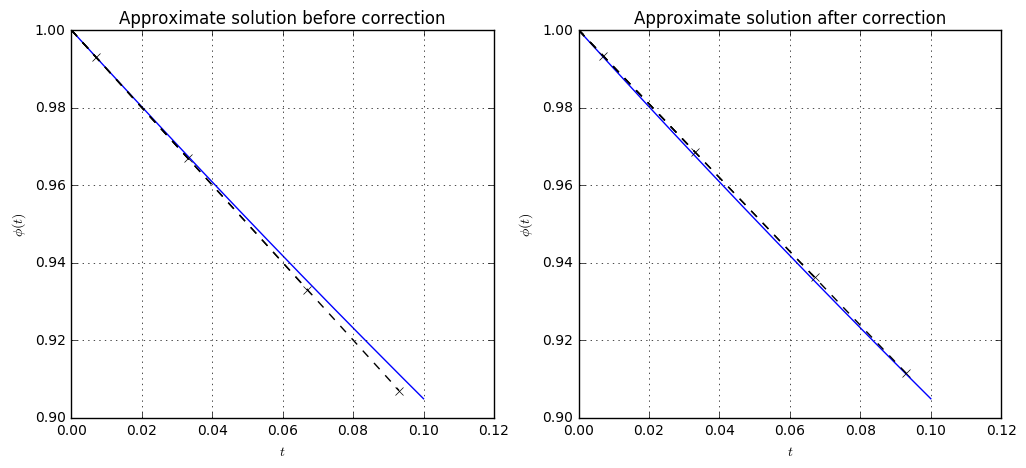

In [2]:
import numpy as np
from matplotlib import pyplot as plt

####################################################################
# Definition of flux function
def FluxFunc(phi, lam):
    return lam * phi
    

# Initial conditions
phi_0 = 1.0
lam  =-1.0

# Analytical solution
phi_ana = lambda t: phi_0 * np.exp(lam * t)

# Discretization parameters
t_0  = 0.0
dt   = 0.1   # timestep
m    = 4      # Gauss-Legendre-Polyorder


'''
-------------------------------------------------------------------------
Initial approximation
-------------------------------------------------------------------------
'''
# 1) Compute Gauss-Legendre-nodes and weights on interval [-1,1]
[Ws, xs, err]= GaussLegendreWeights(m)

# 2) Transform Gauss-Legendre-nodes to interval [t_n, t_(n+1)]
ts = []
for xi in xs:
    ts.append(0.5*((2*t_0+dt)+ xi*dt))

# 3) Compute initial approximation for all Gauss-Legendre-nodes
#    using first order euler explicit discretization
phi_n = phi_0
phi_aprx = []
for ti in ts:
    phi_aprx.append(phi_n + ti * FluxFunc(phi_n, lam))

    
# 4) Plot approximate solutions over analytical solution
t_ana = np.linspace(t_0, t_0+dt, 200)
fig1 = plt.figure()
fig1.set_size_inches(12,5)

ax11 = fig1.add_subplot(121)
ax11.plot(t_ana, phi_ana(t_ana), ls='-', c='b')
for i in range(0,len(ts)):
    ax11.plot([t_0, ts[i]], [phi_0, phi_aprx[i]], ls='--', c='k', marker='x')

ax11.set_xlabel(r'$t$')
ax11.set_ylabel(r'$\phi(t)$')
ax11.set_title(r'Approximate solution before correction')
ax11.grid(True)
#plt.show()

print("Errors to analytical solution:")
print("--------------------------------")
for i in range(0, len(ts)):
    print("t : %f - err : %f" % (ts[i], abs(phi_aprx[i]- phi_ana(ts[i]))))


'''
-------------------------------------------------------------------------
Successive correction
-------------------------------------------------------------------------
'''
Ncorr = 2         # Number of correction steps
e_n = [0.0] * m   # Residuals for previous timestep
d_n = [0.0] * m   # Errors for previous timestep

e_aprx = [0.0] * m
d_aprx = [0.0] * m

for n_corr in range(0, Ncorr):

    # 5) Compute the approximate residual function
    for i, ti in enumerate(ts):
        # Integration matrix for current interval [t0, ti]
        S = []
        for wi in Ws:
            S.append(0.5*(ti-t_0)*wi)

        # Compute integral 
        int_F = 0.0
        for j in range(0, len(S)):
            int_F += S[j] * FluxFunc(phi_aprx[j], lam)

        # Compute approximal residual for current sub-timestep
        e_aprx[i] = phi_n + int_F - phi_aprx[i]


    # 6) Compute the approximate error function 
    #    using first order euler explicit formular
    for i, ti in enumerate(ts):
        dF = FluxFunc(phi_aprx[i] + d_n[i], lam) - FluxFunc(phi_aprx[i], lam)
        de = e_aprx[i] - e_n[i]
        d_aprx[i] = d_n[i] + (ti-t_0) * dF + de

    print("\nApproximated Errors to analytical solution after correction step %d:" % n_corr)
    print("--------------------------------")
    for i in range(0, len(ts)):
        print("t : %f - err : %f" % (ts[i], abs(d_aprx[i])))
        
    # 7) Update approximate solution
    for i in range(0, len(ts)):
        phi_aprx[i] += d_aprx[i]
        


# 4) Plot new approximate solutions over analytical solution
t_ana = np.linspace(t_0, t_0+dt, 200)
ax12 = fig1.add_subplot(122)
ax12.plot(t_ana, phi_ana(t_ana), ls='-', c='b')
for i in range(0,len(ts)):
    ax12.plot([t_0, ts[i]], [phi_0, phi_aprx[i]], ls='--', c='k', marker='x')

ax12.set_xlabel(r'$t$')
ax12.set_ylabel(r'$\phi(t)$')
ax12.set_title(r'Approximate solution after correction')
ax12.grid(True)
plt.show()


## Example for full time integration using Gauss-Legendre nodes

Physical timestep: 9.305682e-02 - Calculating solution for 11 timesteps


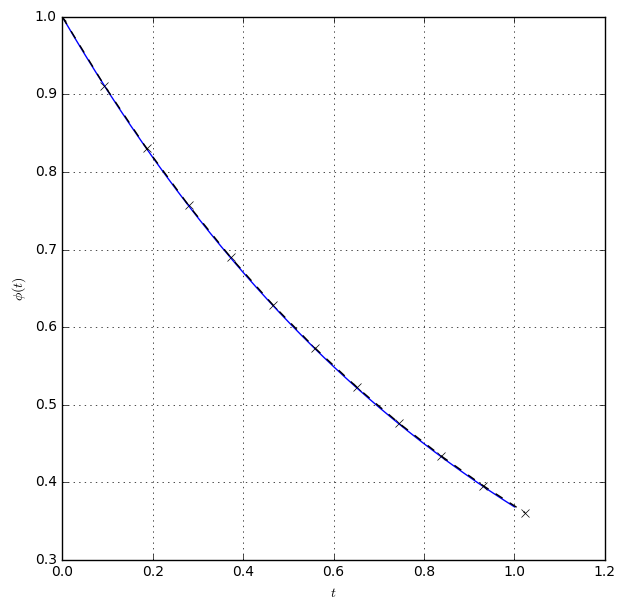

In [3]:
import numpy as np
from matplotlib import pyplot as plt

####################################################################
# Definition of flux function
def FluxFunc(phi, lam):
    return lam * phi
    

# Initial conditions
#--------------------------------------------------------------------
phi_0 = 1.0
lam  =-1.0

# Analytical solution
#--------------------------------------------------------------------
phi_ana = lambda t: phi_0 * np.exp(lam * t)

# Discretization parameters
#--------------------------------------------------------------------
t_0  = 0.0    # start simulation time
t_1  = 1.0    # end simulation time
dt   = 0.1    # timestep
m    = 4      # Gauss-Legendre-Polyorder
Ncorr = 10         # Number of correction steps

# Initialize arrays
# -------------------------------------------------------------------
e_aprx   = [0.0] * m   # Approximate residuals at current sub-timesteps
d_aprx   = [0.0] * m   # Approximate errors at current sub-timesteps
phi_aprx = [0.0] * m   # Approximate solution at current sub-timesteps

phi_n    = phi_0       # Solution of previous timestep
e_n      = 0.0 #[0.0] * m   # Residuals at previous sub-timesteps
d_n      = 0.0 #[0.0] * m   # Errors at previous at sub-timesteps


'''
-------------------------------------------------------------------------
Initialize Gauss-Legendre nodes and weights
-------------------------------------------------------------------------
'''
# 1) Compute Gauss-Legendre-nodes and weights on interval [-1,1]
[Ws, xs, err]= GaussLegendreWeights(m)

# 2) Transform Gauss-Legendre-nodes to interval [t_n, t_(n+1)]
ts = [0.0] * m
for i, xi in enumerate(xs):
    ts[i] = 0.5*((2*t_0+dt)+ xi*dt)

'''
-------------------------------------------------------------------------
"Real" timestep is defined through last Gauss-Legendre-node
-> Compute number of timesteps for this this delta t
-------------------------------------------------------------------------
'''
dt_sim = ts[-1]
Nt_sim = int((t_1-t_0) / dt_sim) + 1
T_sim = [0.0] * (Nt_sim + 1)
phi_sim = [0.0] * (Nt_sim + 1)
phi_sim[0] = phi_0
print("Physical timestep: %e - Calculating solution for %d timesteps" % (dt_sim, Nt_sim))
 
'''
-------------------------------------------------------------------------
Start Time loop
-------------------------------------------------------------------------
'''
for n_sim in range(0, Nt_sim):
    #--------------------------------------------------------------------
    # Compute initial approximation for all Gauss-Legendre-nodes
    # using first order euler explicit discretization
    #--------------------------------------------------------------------
    for i, ti in enumerate(ts):
        phi_aprx[i] = phi_n + ti * FluxFunc(phi_n, lam)

    #--------------------------------------------------------------------
    # Perform successive correction steps
    #--------------------------------------------------------------------
    for n_corr in range(0, Ncorr):

        # 1) Compute the approximate residual function
        for i, ti in enumerate(ts):
            # Integration matrix for current interval [t0, ti]
            S = []
            for wi in Ws:
                S.append(0.5*ti*wi)

            # Compute integral 
            int_F = 0.0
            for j in range(0, len(S)):
                int_F += S[j] * FluxFunc(phi_aprx[j], lam)

            # Compute approximal residual for current sub-timestep
            e_aprx[i] = phi_n + int_F - phi_aprx[i]


        # 2) Compute the approximate error function 
        #    using first order euler explicit formular
        for i, ti in enumerate(ts):
            dF = FluxFunc(phi_aprx[i] + d_n, lam) - FluxFunc(phi_aprx[i], lam)
            de = e_aprx[i] - e_n
            d_aprx[i] = d_n + (ti-t_0) * dF + de

        # 3) Update approximate solution
        for i in range(0, len(ts)):
            phi_aprx[i] += d_aprx[i]
        
    #--------------------------------------------------------------------
    # Update final solution
    #--------------------------------------------------------------------
    phi_n = phi_aprx[-1]
    phi_sim[n_sim+1] = phi_aprx[-1]
    
    e_n = e_aprx[-1]
    d_n = d_aprx[-1]
    
    # Update physical simulation time
    T_sim[n_sim+1] = t_0 + (n_sim+1)*ts[-1]


'''
-------------------------------------------------------------------------
Plot solution
-------------------------------------------------------------------------
'''
t_ana = np.linspace(0, t_1, 200)
fig1 = plt.figure()
fig1.set_size_inches(7,7)

ax11 = fig1.add_subplot(111)
ax11.plot(t_ana, phi_ana(t_ana), ls='-', c='b')

ax11.plot(T_sim, phi_sim, ls='--', c='k', marker='x')

ax11.set_xlabel(r'$t$')
ax11.set_ylabel(r'$\phi(t)$')
ax11.grid(True)
plt.show()


## Example for single timestep using Gauss-Radau nodes

Consider the one-dimensional equation system
$$
\frac{d \phi}{dt} = F(t, \phi(t))
$$

Befor any iteration step, the simulation timestep $\Delta t = t_{n+1} - t_{n}$ is divided into $m$ sub-timestep intervals $[t_1, t_2, ..., t_{m-1}, t_{n+1}]$ with
$$
t_n < t_1 < t_2 < ... < t_{m-1} < t_{n+1}.
$$

The $m-1$ interpediate sub-timesteps $\Delta t_i$ are detemined through Gauss-Radau nodes $t_i$ with

$$ 
\begin{bmatrix}
\Delta t_1\\
\Delta t_2\\
...\\
\Delta t_{m}
\end{bmatrix}
= 
\begin{bmatrix}
t_1 - t_n, \\
t_2 - t_n, \\
...\\ 
t_{n+1} - t_n \\
\end{bmatrix}
$$

The Gauss-Radau nodes $t_i$ and the respective quadrature weights $w_i$ for interpolation are pre-computed on the timestep interval $\Delta t$.

### Approximate solution on sub-timesteps
One single step of the spectral deferred correction method takes then the following sub-steps:

First, compute the approximate solution vector $\mathbf{\phi}^{[j]}$ using some arbitrary discretization scheme, e.g. first order euler forward differentation:
$$
\mathbf{\phi}^{[j]} = 
\begin{bmatrix}
\phi_1^{[j]}\\
\phi_2^{[j]}\\
...\\
\phi_{m}^{[j]}
\end{bmatrix}
=
\begin{bmatrix}
\phi^{n} + \Delta t_1 \cdot F(t, \phi^{n}) \\
\phi^{n} + \Delta t_2 \cdot F(t, \phi^{n}) \\
...\\
\phi^{n} + \Delta t_{m} \cdot  F(t, \phi^{n})
\end{bmatrix}
$$

Then perform $k$ correction steps:

### Residual function $\epsilon(t)$
For each correction step, the residual function $\epsilon(t)$ has to be computed through 
$$
\epsilon(t) = \phi^n + \int_{0}^{t} F(\tau, \phi^n) d\tau - \phi^{[j]}(t).
$$

The integration of $F(\tau, \phi^n)$ is approximated through 
$$
\int_{0}^{t} F(\tau, \phi^n) d\tau \approx \mathbf{S} \cdot \mathbf{F}(\phi^{[j]})
$$

with the spectral integration matrix $\mathbf{S}$, that is defined through
$$
\mathbf{S} = \frac{1}{2}
\begin{bmatrix}
\Delta t_1 \cdot w_1 & \Delta t_1 \cdot w_2 & ... & \Delta t_1 \cdot w_m \\
\Delta t_2 \cdot w_1 & \Delta t_2 \cdot w_2 & ... & \Delta t_2 \cdot w_m \\
... & & & \\
\Delta t_m \cdot w_1 & \Delta t_m \cdot w_2 & ... & \Delta t_m \cdot w_m \\
\end{bmatrix}
$$

The entries of $\mathbf{S}$ result from the Gauss-quadrature formular  
$$
\int_{-1}^{1} f(x) dx = \sum_{i=1}^{m} f(x_i) \cdot \alpha_i
$$
for the integral of a function $f(x)$ over the interval $[-1,1]$ and the respective rule to integrate over an arbitrary interval $[a,b]$:
$$
\int_a^b f(t) dt = \frac{b-a}{2} \int_{-1}^{1} f\left(\frac{b-a}{2} x + \frac{a+b}{2}\right) dx = \frac{b-a}{2} \sum_{i=1}^{m} f\left(\frac{b-a}{2} x_i + \frac{a+b}{2}\right) \cdot \alpha_i
$$
whereas the interpolation nodes 
$$t_i = \frac{b-a}{2} x_i + \frac{a+b}{2}
$$ 
are inherently the Gauss-Radau nodes that are used to compute the sub-timestep solutions and in this case $b-a = t_i-t_n = \Delta t_i$.

For every sub-timestep $\Delta t_i$ a residual function $\epsilon_i$ is computed through
$$
\mathbf{\epsilon}^{[j]} = \phi^n +  \mathbf{S} \cdot \mathbf{F}(\phi^{[j]}) - \mathbf{\phi}^{[j]}
$$

### Error function $\delta(t)$
Next, the error function can be computed, which is defined through
$$
\delta(t) = \int_{0}^{t} \left[F(\tau, \phi^{[j]} + \delta) - F(\tau, \phi^[j]) \right] d\tau + \epsilon(t)
$$

It is computed, using following identity:
$$
\delta(t_{m+1}) = \delta(t_m) + \int_{t_m}^{t_{i+m}} \left[F(\tau, \phi^{[j]} + \delta) - F(\tau, \phi^[j]) \right] d\tau + \epsilon{m+1} - \epsilon_m
$$

Let $\delta_m$ be the numerical approximation to $\delta(t_m)$, this equation can be approximated using any discretization scheme, e.g. first order euler explicit:
$$
\delta_{m+1} = \delta_m + \Delta t_m (F(\phi^{[j]}_m + \delta_m) - F(\phi^{[j]}_m)) + \epsilon_{m+1} - \epsilon_{m}
$$

In this case, we calculate the error for every sub-timestep preceedingly from one to another:

$$
\delta_{i}^{[j]} = \delta_n + \Delta t_i (F(\phi_i^{[j]} + \delta_n) - F(\phi^{[j]}_i)) + \epsilon_{i} - \epsilon_{n}
$$

with the error $\delta_n$ and the residual $\epsilon_{n}$ from the previous timestep.

### System of equations
$$ 
\frac{\partial \phi }{\partial t} = F(t, \phi) = \lambda \cdot \phi(t) 
$$
$$
\phi(0) = \phi_0
$$

Analytic solution:
$$
\phi(t) = \phi_0 \cdot e^{\lambda t}
$$

Discretization through Euler explicit:
$$ 
\frac{\partial \phi }{\partial t} \approx \frac{\phi^{n+1} - \phi^{n}}{\Delta t}
$$


Full discretized equation:
$$
\frac{\phi^{n+1} - \phi^{n}}{\Delta t} = \lambda \phi^n
$$
$$
\phi^{n+1} = (1 + \Delta t \cdot \lambda) \cdot  \phi^n 
$$

Errors to analytical solution:
--------------------------------
t : 0.021234 - err : 0.000224
t : 0.059053 - err : 0.001710
t : 0.091141 - err : 0.004030
t : 0.100000 - err : 0.004837

Approximated Errors to analytical solution after correction step 0:
--------------------------------
t : 0.021234 - err : 0.001194
t : 0.059053 - err : 0.003322
t : 0.091141 - err : 0.005127
t : 0.100000 - err : 0.005625

Approximated Errors to analytical solution after correction step 1:
--------------------------------
t : 0.021234 - err : 0.000067
t : 0.059053 - err : 0.000187
t : 0.091141 - err : 0.000288
t : 0.100000 - err : 0.000316


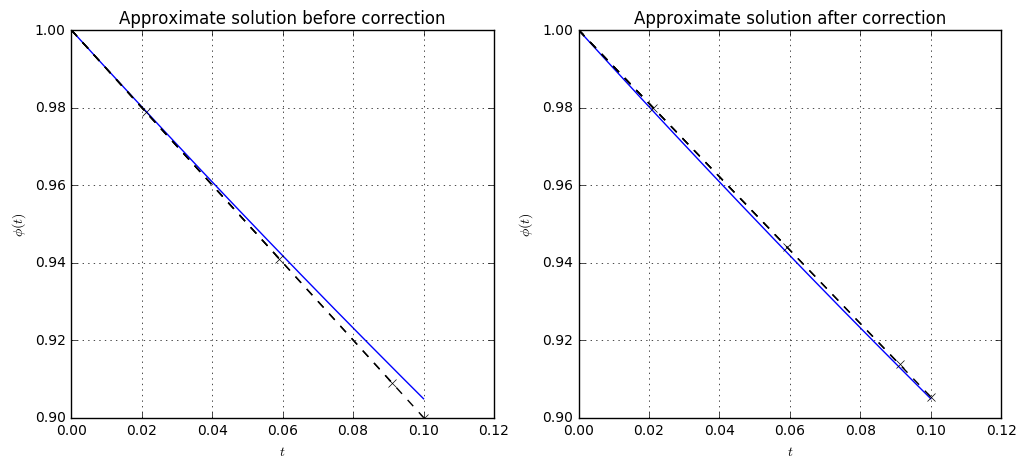

In [4]:
import numpy as np
from matplotlib import pyplot as plt

'''
=====================================================================================================

Definition of auxiliary functions

=====================================================================================================
'''


'''
------------------------------------------------------------------
Function: Evaluates the Legendre-Polynom P_n(x) of order n
          at point x
------------------------------------------------------------------
'''
def Legendre(n,x):
    x=np.array(x)
    if (n==0):
        return 1.0
    elif (n==1):
        return x
    else:
        return ((2.0*n-1.0)*x*Legendre(n-1,x)-(n-1)*Legendre(n-2,x))/n
    
    
'''
------------------------------------------------------------------
Function: Evaluates the derivative of the Legendre-Polynom P_n(x) 
          of order n at point x
------------------------------------------------------------------
'''
def DLegendre(n,x):
    x=np.array(x)
    if (n==0):
        return 0
    elif (n==1):
        return 1.0
    else:
        return (n/(x**2-1.0))*(x*Legendre(n,x)-Legendre(n-1,x))
    
    
'''
------------------------------------------------------------------
Function: Calcuate the Gauss-Radau roots using 
          Newton-Raphson method
------------------------------------------------------------------
'''
def RadauRoots(n, tolerance=1e-20, iter_max=10000):
    roots = []
    if n < 2:
        return roots # bad polyorder - no roots can be found
    else:
        # First root is 1
        roots.append(1)
        # The remaining roots are computed through newtpn-raphson
        for i in range(1, n):
            x = np.cos(np.pi*(i-0.25)/(n+0.5))
            error = 10*tolerance
            iters = 0
            iiters = 0
            while (error>tolerance) and (iters<iter_max):
                while (1.+x < 0.0) and (iiters<1000):
                    x += 1. / (n-1)
                f    =  (Legendre(n-1,x) + Legendre(n,x)) / (1.+ x)
                df_1 =  (DLegendre(n-1,x) + DLegendre(n,x)) / (1.+ x)
                df_2 = -(Legendre(n-1,x) +  Legendre(n,x)) / (1.+ x)**0.5
                df = df_1 + df_2
                delta = -f / df
                x = x + delta
                iters=iters+1
                error=abs(delta)
            roots.append(x)
            if (iters>iter_max-1):
                print("Node %d: Stopped iteration before final accuracy." % i)
        
    # Return roots in ascending order
    return roots[-1::-1]


'''
------------------------------------------------------------------
Function: Calcuate the Gauss-Radau weights w_i
------------------------------------------------------------------
'''
def GaussRadauWeights(n, tolerance=1e-20, iter_max=10000):
    w=[]
    roots = RadauRoots(n, tolerance=tolerance, iter_max=iter_max)
    if len(roots) > 0:
        for i, ri in enumerate(roots):
            if i < len(roots)-1:
                wi = 1.0 / ( (1.0 - ri) * DLegendre(n-1, ri)**2 )
            else:
                wi = 2. / (n*n)
            w.append(wi)
    else:
        print("Error: Could not compute Gauss-Radau weights")
        print("No roots available")
        
    return [w, roots]



'''
------------------------------------------------------------------
Function: Calculate the flux function of the differential equation
------------------------------------------------------------------
'''
def FluxFunc(phi, lam):
    return lam * phi


'''
=====================================================================================================

Spectral Deferred Correction Method 

=====================================================================================================
'''
# Initial conditions
phi_0 = 1.0
lam   =-1.0

# Analytical solution
phi_ana = lambda t: phi_0 * np.exp(lam * t)

# Discretization parameters
t_0  = 0.0
dt   = 0.1   # timestep
m    = 4      # Gauss-Legendre-Polyorder



'''
-------------------------------------------------------------------------
Initial approximation
-------------------------------------------------------------------------
'''
# 1) Compute Gauss-Radau-nodes and weights on interval [-1,1]
[Ws, xs] = GaussRadauWeights(m, tolerance=1e-16, iter_max=10000)

# 2) Transform Gauss-Radau-nodes to interval [t_n, t_(n+1)]
ts = []
for xi in xs:
    ts.append(0.5*((2*t_0+dt)+ xi*dt))

# 3) Compute initial approximation for all Gauss-Radau-nodes
#    using first order euler explicit discretization
phi_n = phi_0
e_n = [0.0] * m   # Residuals for previous timestep
d_n = [0.0] * m   # Errors for previous timestep
phi_aprx = []
for ti in ts:
    phi_aprx.append(phi_n + ti * FluxFunc(phi_n, lam))

# 4) Plot approximate solutions over analytical solution
t_ana = np.linspace(t_0, t_0+dt, 200)
fig1 = plt.figure()
fig1.set_size_inches(12,5)

ax11 = fig1.add_subplot(121)
ax11.plot(t_ana, phi_ana(t_ana), ls='-', c='b')
for i in range(0,len(ts)):
    ax11.plot([t_0, ts[i]], [phi_0, phi_aprx[i]], ls='--', c='k', marker='x')

ax11.set_xlabel(r'$t$')
ax11.set_ylabel(r'$\phi(t)$')
ax11.set_title(r'Approximate solution before correction')
ax11.grid(True)

print("Errors to analytical solution:")
print("--------------------------------")
for i in range(0, len(ts)):
    print("t : %f - err : %f" % (ts[i], abs(phi_aprx[i]- phi_ana(ts[i]))))


    
    
'''
-------------------------------------------------------------------------
Successive correction
-------------------------------------------------------------------------
'''
Ncorr = 2         # Number of correction steps


e_aprx = [0.0] * m
d_aprx = [0.0] * m

for n_corr in range(0, Ncorr):

    # 5) Compute the approximate residual function
    for i, ti in enumerate(ts):
        # Integration matrix for current interval [t0, ti]
        S = []
        for wi in Ws:
            S.append(0.5*(ti-t_0)*wi)

        # Compute integral 
        int_F = 0.0
        for j in range(0, len(S)):
            int_F += S[j] * FluxFunc(phi_aprx[j], lam)

        # Compute approximal residual for current sub-timestep
        e_aprx[i] = phi_n + int_F - phi_aprx[i]


    # 6) Compute the approximate error function 
    #    using first order euler explicit formular
    for i, ti in enumerate(ts):
        dF = FluxFunc(phi_aprx[i] + d_n[i], lam) - FluxFunc(phi_aprx[i], lam)
        de = e_aprx[i] - e_n[i]
        d_aprx[i] = d_n[i] + (ti-t_0) * dF + de
        #if (i<1):
        #    dF = FluxFunc(phi_aprx[i] + d_n, lam) - FluxFunc(phi_aprx[i], lam)
        #    de = e_aprx[i] - e_n
        #    d_aprx[i] = d_n + (ti-t_0) * dF + de
        #else:
        #    dF = FluxFunc(phi_aprx[i] + d_aprx[i-1], lam) - FluxFunc(phi_aprx[i], lam)
        #    de = e_aprx[i] - e_aprx[i-1]
        #    d_aprx[i] = d_aprx[i-1] + (ti-ts[i-1]) * dF + de
            
        

    print("\nApproximated Errors to analytical solution after correction step %d:" % n_corr)
    print("--------------------------------")
    for i in range(0, len(ts)):
        print("t : %f - err : %f" % (ts[i], abs(d_aprx[i])))
        
    # 7) Update approximate solution
    for i in range(0, len(ts)):
        phi_aprx[i] += d_aprx[i]
        


# 4) Plot new approximate solutions over analytical solution
t_ana = np.linspace(t_0, t_0+dt, 200)
ax12 = fig1.add_subplot(122)
ax12.plot(t_ana, phi_ana(t_ana), ls='-', c='b')
for i in range(0,len(ts)):
    ax12.plot([t_0, ts[i]], [phi_0, phi_aprx[i]], ls='--', c='k', marker='x')

ax12.set_xlabel(r'$t$')
ax12.set_ylabel(r'$\phi(t)$')
ax12.set_title(r'Approximate solution after correction')
ax12.grid(True)
plt.show()
